# Сравнение алгоритмов градиентного бустинга

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, log_loss, classification_report, 
                            confusion_matrix, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


Библиотеки загружены успешно!


## Реализация класса градиентного бустинга

In [ ]:
class GradientBoosting:
    """
    Реализация градиентного бустинга
    """
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 min_samples_split=2, loss='mse'):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.loss = loss
        self.models = []
        self.initial_prediction = None
        self.is_classification = (loss == 'log_loss')
        
    def _compute_gradient(self, y_true, y_pred):
        """Вычисление градиента функции потерь"""
        if self.loss == 'mse':
            return y_pred - y_true
        elif self.loss == 'log_loss':
            return y_pred - y_true
        else:
            raise ValueError(f"Неизвестная функция потерь: {self.loss}")
    
    def _sigmoid(self, x):
        """Сигмоидная функция для классификации"""
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def fit(self, X, y, verbose=True):
        """Обучение модели градиентного бустинга"""
        X = np.array(X)
        y = np.array(y).ravel()
        n_samples = X.shape[0]
        
        # Начальное предсказание
        if self.loss == 'mse':
            self.initial_prediction = np.mean(y)
            y_pred = np.full(n_samples, self.initial_prediction)
        elif self.loss == 'log_loss':
            mean_y = np.mean(y)
            if mean_y == 0:
                self.initial_prediction = -10
            elif mean_y == 1:
                self.initial_prediction = 10
            else:
                self.initial_prediction = np.log(mean_y / (1 - mean_y))
            y_pred = np.full(n_samples, self.initial_prediction)
        
        self.train_errors = []
        iterator = tqdm(range(self.n_estimators), desc="Обучение моделей") if verbose else range(self.n_estimators)
        
        for i in iterator:
            residuals = -self._compute_gradient(y, y_pred)
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=42
            )
            tree.fit(X, residuals)
            self.models.append(tree)
            tree_pred = tree.predict(X)
            y_pred = y_pred + self.learning_rate * tree_pred
            
            if self.loss == 'mse':
                from sklearn.metrics import mean_squared_error
                error = mean_squared_error(y, y_pred)
            elif self.loss == 'log_loss':
                y_pred_proba = self._sigmoid(y_pred)
                error = log_loss(y, y_pred_proba)
            self.train_errors.append(error)
        
        return self
    
    def predict(self, X):
        """Предсказание для новых данных"""
        X = np.array(X)
        n_samples = X.shape[0]
        predictions = np.full(n_samples, self.initial_prediction)
        
        for tree in self.models:
            predictions += self.learning_rate * tree.predict(X)
        
        if self.is_classification:
            predictions = self._sigmoid(predictions)
            return predictions
        else:
            return predictions
    
    def predict_classes(self, X, threshold=0.5):
        """Предсказание классов для классификации"""
        if not self.is_classification:
            raise ValueError("Метод predict_classes доступен только для классификации")
        probabilities = self.predict(X)
        return (probabilities >= threshold).astype(int)

Класс GradientBoosting определен!


## Загрузка данных

In [101]:
train_df = pd.read_csv('../data/train_c.csv')
test_df = pd.read_csv('../data/test_c.csv')

print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")
print(f"\nРаспределение целевой переменной LoanApproved:")
print(train_df['LoanApproved'].value_counts())
print(f"Процент одобренных: {train_df['LoanApproved'].mean()*100:.2f}%")

Размер обучающей выборки: (11017, 35)
Размер тестовой выборки: (5000, 35)

Распределение целевой переменной LoanApproved:
LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64
Процент одобренных: 51.18%


## Подготовка данных

In [102]:
print("=" * 70)
print("ПОДГОТОВКА ДАННЫХ")
print("=" * 70)

train_processed = train_df.copy()
test_processed = test_df.copy()

print("\n1. Обработка пропущенных значений...")
missing_train = train_processed.isnull().sum()

if missing_train.sum() > 0:
    print(f"   Пропущенных значений в train: {missing_train.sum()}")
    numeric_cols = train_processed.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if train_processed[col].isnull().sum() > 0:
            median_val = train_processed[col].median()
            train_processed[col].fillna(median_val, inplace=True)
            if col in test_processed.columns:
                test_processed[col].fillna(median_val, inplace=True)
    
    categorical_cols = train_processed.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        if train_processed[col].isnull().sum() > 0:
            mode_val = train_processed[col].mode()
            if len(mode_val) > 0:
                train_processed[col].fillna(mode_val[0], inplace=True)
                if col in test_processed.columns:
                    test_processed[col].fillna(mode_val[0], inplace=True)
            else:
                train_processed[col].fillna('Unknown', inplace=True)
                if col in test_processed.columns:
                    test_processed[col].fillna('Unknown', inplace=True)
    print("   ✓ Пропущенные значения заполнены")
else:
    print("   ✓ Пропущенных значений нет")

print("\n2. Кодирование категориальных признаков...")
categorical_cols = train_processed.select_dtypes(include=['object']).columns.tolist()
if 'ApplicationDate' in categorical_cols:
    categorical_cols.remove('ApplicationDate')

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_processed[col] = le.fit_transform(train_processed[col].astype(str))
    if col in test_processed.columns:
        test_processed[col] = test_processed[col].astype(str)
        test_processed[col] = test_processed[col].map(
            dict(zip(le.classes_, le.transform(le.classes_)))
        ).fillna(-1).astype(int)
    label_encoders[col] = le
print(f"   ✓ Закодировано {len(categorical_cols)} категориальных признаков")

print("\n3. Обработка даты...")
if 'ApplicationDate' in train_processed.columns:
    train_processed['ApplicationDate'] = pd.to_datetime(train_processed['ApplicationDate'], errors='coerce')
    train_processed['Year'] = train_processed['ApplicationDate'].dt.year
    train_processed['Month'] = train_processed['ApplicationDate'].dt.month
    train_processed['DayOfWeek'] = train_processed['ApplicationDate'].dt.dayofweek
    train_processed = train_processed.drop('ApplicationDate', axis=1)
    
    if 'ApplicationDate' in test_processed.columns:
        test_processed['ApplicationDate'] = pd.to_datetime(test_processed['ApplicationDate'], errors='coerce')
        test_processed['Year'] = test_processed['ApplicationDate'].dt.year
        test_processed['Month'] = test_processed['ApplicationDate'].dt.month
        test_processed['DayOfWeek'] = test_processed['ApplicationDate'].dt.dayofweek
        test_processed = test_processed.drop('ApplicationDate', axis=1)
    print("   ✓ Извлечены признаки из даты")

print("\n4. Подготовка данных для обучения...")

X_train_full = train_processed.drop('LoanApproved', axis=1)
y_train_full = train_processed['LoanApproved']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

X_test = X_val
y_test = y_val

if 'LoanApproved' in test_processed.columns:
    X_test_final = test_processed.drop('LoanApproved', axis=1)
    y_test_final = test_processed['LoanApproved']
else:
    X_test_final = test_processed.copy()
    y_test_final = None

X_test = X_test[X_train.columns]
if y_test_final is None:
    X_test_final = X_test_final[X_train.columns]

print("\n5. Масштабирование признаков...")
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

X_train_full_scaled = pd.DataFrame(
    scaler.transform(X_train_full),
    columns=X_train_full.columns,
    index=X_train_full.index
)

print("   ✓ Признаки масштабированы")
print("   ✓ Подготовлены данные для обучения на полном датасете")

print("\n" + "=" * 70)
print("ДАННЫЕ ПОДГОТОВЛЕНЫ!")
print("=" * 70)

ПОДГОТОВКА ДАННЫХ

1. Обработка пропущенных значений...
   Пропущенных значений в train: 23059
   ✓ Пропущенные значения заполнены

2. Кодирование категориальных признаков...
   ✓ Закодировано 5 категориальных признаков

3. Обработка даты...
   ✓ Извлечены признаки из даты

4. Подготовка данных для обучения...

5. Масштабирование признаков...
   ✓ Признаки масштабированы
   ✓ Подготовлены данные для обучения на полном датасете

ДАННЫЕ ПОДГОТОВЛЕНЫ!


## Сравнение всех алгоритмов градиентного бустинга

In [103]:
n_estimators = 100
learning_rate = 0.1
max_depth = 3

all_models = {}
all_predictions = {}
all_probabilities = {}

In [105]:
print("1. Обучение sklearn GradientBoostingClassifier...")
sklearn_gb = GradientBoostingClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    random_state=42
)
sklearn_gb.fit(X_train_scaled.values, y_train.values)
if y_test is not None:
    sklearn_pred = sklearn_gb.predict(X_test_scaled.values)
    sklearn_proba = sklearn_gb.predict_proba(X_test_scaled.values)[:, 1]
    all_models['Sklearn GB'] = {
        'model': sklearn_gb,
        'predictions': sklearn_pred,
        'probabilities': sklearn_proba
    }
    all_predictions['Sklearn GB'] = sklearn_pred
    all_probabilities['Sklearn GB'] = sklearn_proba

print("2. Обучение XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled.values, y_train.values)
if y_test is not None:
    xgb_pred = xgb_model.predict(X_test_scaled.values)
    xgb_proba = xgb_model.predict_proba(X_test_scaled.values)[:, 1]
    all_models['XGBoost'] = {
        'model': xgb_model,
        'predictions': xgb_pred,
        'probabilities': xgb_proba
    }
    all_predictions['XGBoost'] = xgb_pred
    all_probabilities['XGBoost'] = xgb_proba

print("3. Обучение LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train_scaled.values, y_train.values)
if y_test is not None:
    lgb_pred = lgb_model.predict(X_test_scaled.values)
    lgb_proba = lgb_model.predict_proba(X_test_scaled.values)[:, 1]
    all_models['LightGBM'] = {
        'model': lgb_model,
        'predictions': lgb_pred,
        'probabilities': lgb_proba
    }
    all_predictions['LightGBM'] = lgb_pred
    all_probabilities['LightGBM'] = lgb_proba

print("4. Обучение CatBoost...")
catboost_model = CatBoostClassifier(
    iterations=n_estimators,
    learning_rate=learning_rate,
    depth=max_depth,
    random_state=42,
    verbose=False,
    loss_function='Logloss'
)
catboost_model.fit(X_train_scaled.values, y_train.values)
if y_test is not None:
    catboost_pred = catboost_model.predict(X_test_scaled.values)
    catboost_proba = catboost_model.predict_proba(X_test_scaled.values)[:, 1]
    all_models['CatBoost'] = {
        'model': catboost_model,
        'predictions': catboost_pred,
        'probabilities': catboost_proba
    }
    all_predictions['CatBoost'] = catboost_pred
    all_probabilities['CatBoost'] = catboost_proba


1. Обучение sklearn GradientBoostingClassifier...
2. Обучение XGBoost...
3. Обучение LightGBM...
4. Обучение CatBoost...


In [107]:
if y_test is not None and len(all_models) > 0:
    print("ВЫЧИСЛЕНИЕ МЕТРИК")
    print("=" * 80)
    
    detailed_results = {}
    
    for model_name, model_data in all_models.items():
        pred = model_data['predictions']
        proba = model_data['probabilities']
        
        metrics = {
            'Accuracy': accuracy_score(y_test, pred),
            'Precision': precision_score(y_test, pred, zero_division=0),
            'Recall': recall_score(y_test, pred, zero_division=0),
            'F1-Score': f1_score(y_test, pred, zero_division=0),
            'Log Loss': log_loss(y_test, proba),
            'ROC-AUC': roc_auc_score(y_test, proba)
        }
        
        detailed_results[model_name] = metrics
    
    print(f"\n{'Модель':<15} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Log Loss':<12} {'ROC-AUC':<12}")
    print("-" * 90)
    for model_name, metrics in detailed_results.items():
        print(f"{model_name:<15} {metrics['Accuracy']:<12.4f} {metrics['Precision']:<12.4f} "
              f"{metrics['Recall']:<12.4f} {metrics['F1-Score']:<12.4f} {metrics['Log Loss']:<12.4f} "
              f"{metrics['ROC-AUC']:<12.4f}")
    
    print("\n" + "=" * 80)
    print("ЛУЧШИЕ МОДЕЛИ ПО МЕТРИКАМ")
    print("=" * 80)
    
    best_by_metric = {
        'Accuracy': max(detailed_results.items(), key=lambda x: x[1]['Accuracy']),
        'Precision': max(detailed_results.items(), key=lambda x: x[1]['Precision']),
        'Recall': max(detailed_results.items(), key=lambda x: x[1]['Recall']),
        'F1-Score': max(detailed_results.items(), key=lambda x: x[1]['F1-Score']),
        'ROC-AUC': max(detailed_results.items(), key=lambda x: x[1]['ROC-AUC']),
        'Log Loss': min(detailed_results.items(), key=lambda x: x[1]['Log Loss'])
    }
    
    for metric_name, (model_name, metrics) in best_by_metric.items():
        print(f"{metric_name:<15}: {model_name:<15} ({metrics[metric_name]:.4f})")
    
    best_model_name = best_by_metric['F1-Score'][0]
    
    print("\n" + "=" * 80)
    print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
    print("=" * 80)
    print(f"Выбрана по метрике F1-Score (баланс Precision и Recall)")
    print(f"\nМетрики лучшей модели:")
    for metric_name, value in detailed_results[best_model_name].items():
        print(f"  {metric_name}: {value:.4f}")
    
    # Сохраняем информацию о лучшей модели
    best_model_info = {
        'name': best_model_name,
        'metrics': detailed_results[best_model_name],
        'model': all_models[best_model_name]['model']
    }
    
    print(f"\nЛучшая модель сохранена для дальнейшего использования")
    
else:
    print("Тестовые метки отсутствуют, метрики не могут быть вычислены")
    print("Все модели обучены и готовы к использованию")

ВЫЧИСЛЕНИЕ МЕТРИК

Модель          Accuracy     Precision    Recall       F1-Score     Log Loss     ROC-AUC     
------------------------------------------------------------------------------------------
Sklearn GB      0.9283       0.9294       0.9373       0.9333       0.1752       0.9822      
XGBoost         0.9260       0.9248       0.9381       0.9314       0.1726       0.9823      
LightGBM        0.9265       0.9285       0.9347       0.9316       0.1724       0.9824      
CatBoost        0.9297       0.9282       0.9415       0.9348       0.1764       0.9818      

ЛУЧШИЕ МОДЕЛИ ПО МЕТРИКАМ
Accuracy       : CatBoost        (0.9297)
Precision      : Sklearn GB      (0.9294)
Recall         : CatBoost        (0.9415)
F1-Score       : CatBoost        (0.9348)
ROC-AUC        : LightGBM        (0.9824)
Log Loss       : LightGBM        (0.1724)

ЛУЧШАЯ МОДЕЛЬ: CatBoost
Выбрана по метрике F1-Score (баланс Precision и Recall)

Метрики лучшей модели:
  Accuracy: 0.9297
  Precision: 0.92

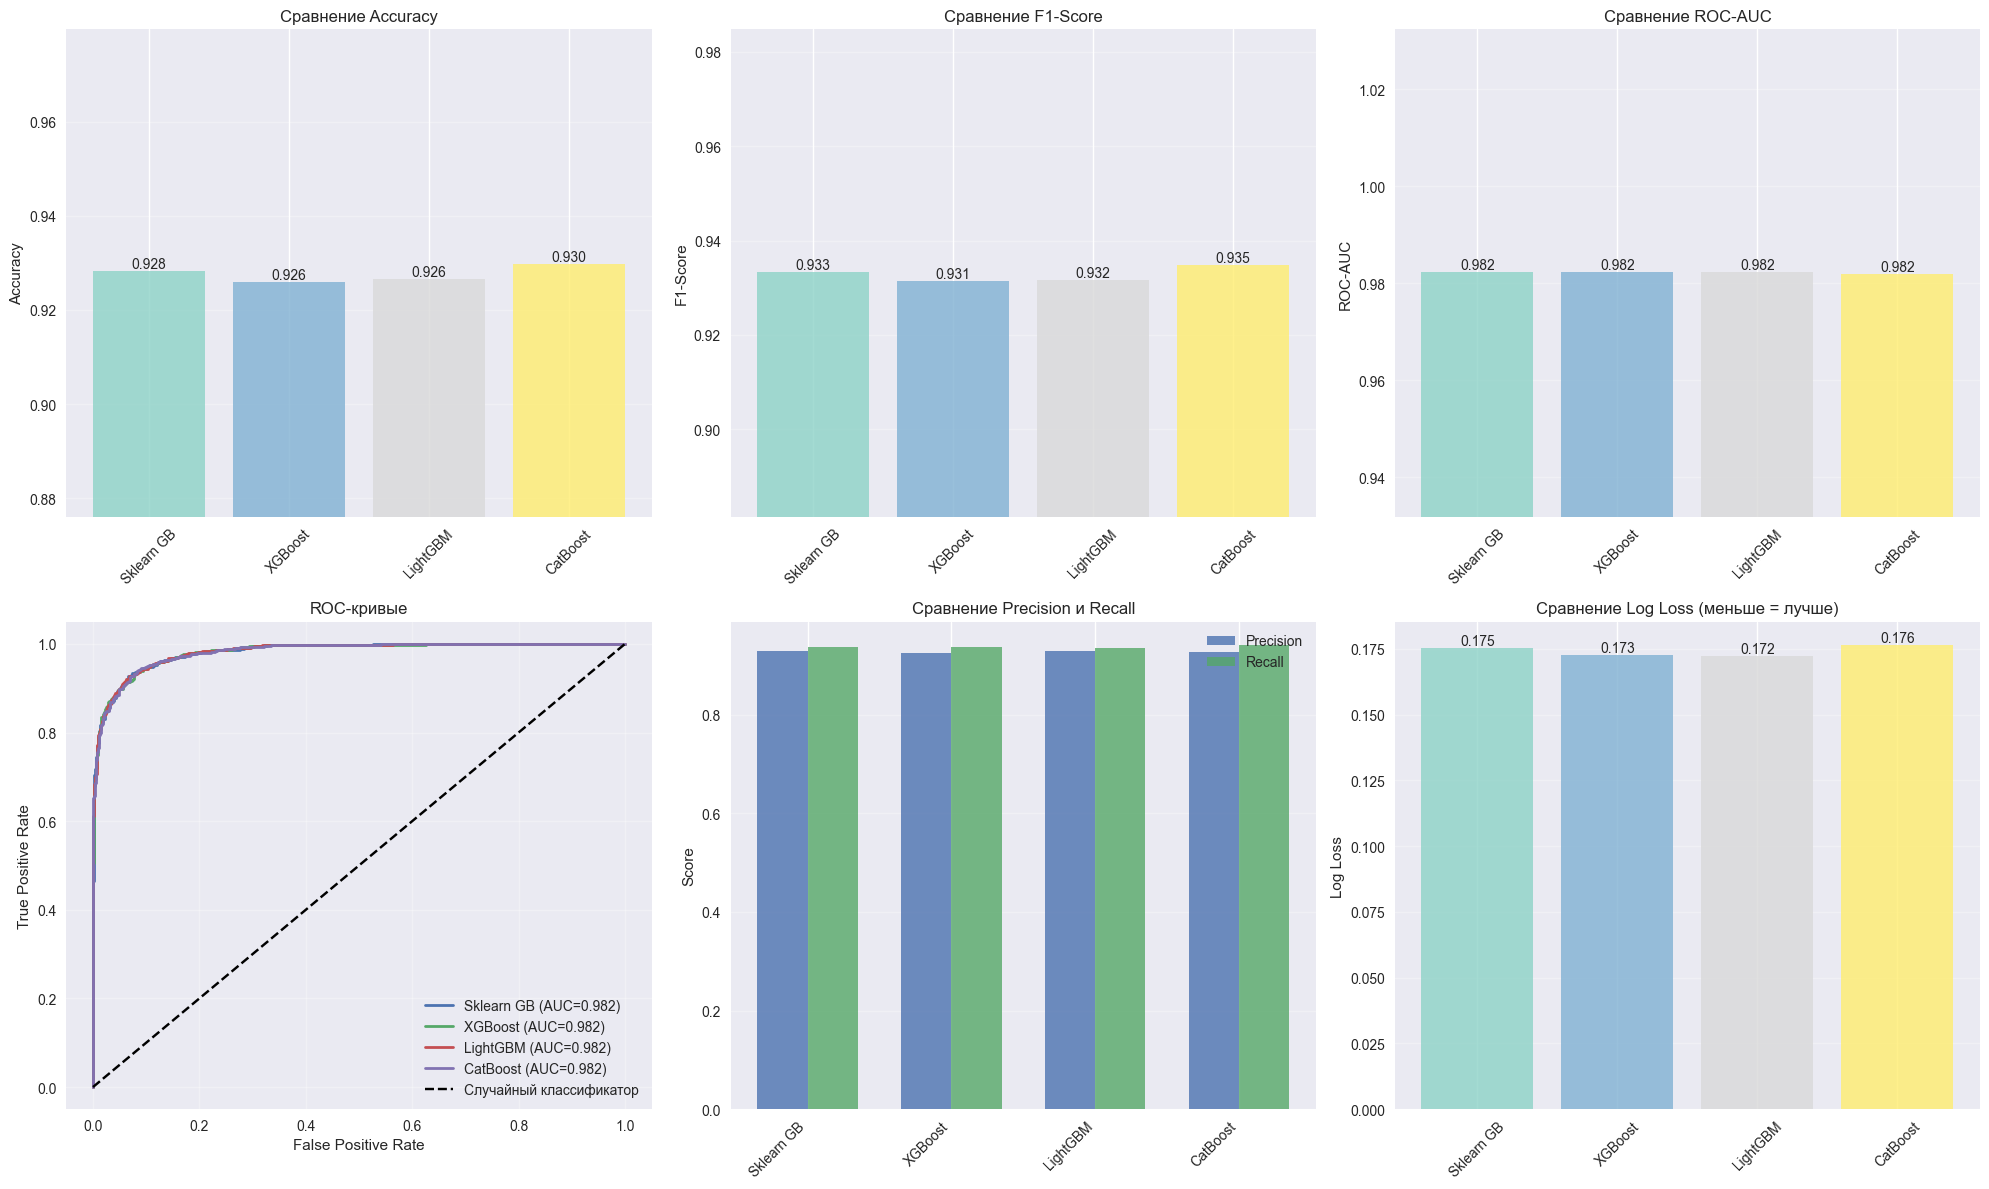

In [109]:
if y_test is not None and len(all_models) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    model_names = list(detailed_results.keys())
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
    
    accuracies = [detailed_results[m]['Accuracy'] for m in model_names]
    axes[0, 0].bar(model_names, accuracies, color=colors, alpha=0.8)
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Сравнение Accuracy')
    axes[0, 0].set_ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(accuracies):
        axes[0, 0].text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    f1_scores = [detailed_results[m]['F1-Score'] for m in model_names]
    axes[0, 1].bar(model_names, f1_scores, color=colors, alpha=0.8)
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].set_title('Сравнение F1-Score')
    axes[0, 1].set_ylim([min(f1_scores) - 0.05, max(f1_scores) + 0.05])
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(f1_scores):
        axes[0, 1].text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    roc_aucs = [detailed_results[m]['ROC-AUC'] for m in model_names]
    axes[0, 2].bar(model_names, roc_aucs, color=colors, alpha=0.8)
    axes[0, 2].set_ylabel('ROC-AUC')
    axes[0, 2].set_title('Сравнение ROC-AUC')
    axes[0, 2].set_ylim([min(roc_aucs) - 0.05, max(roc_aucs) + 0.05])
    axes[0, 2].tick_params(axis='x', rotation=45)
    axes[0, 2].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(roc_aucs):
        axes[0, 2].text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    for model_name, proba in all_probabilities.items():
        fpr, tpr, _ = roc_curve(y_test, proba)
        auc = roc_auc_score(y_test, proba)
        axes[1, 0].plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})', linewidth=2)
    axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC-кривые')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    precisions = [detailed_results[m]['Precision'] for m in model_names]
    recalls = [detailed_results[m]['Recall'] for m in model_names]
    x = np.arange(len(model_names))
    width = 0.35
    axes[1, 1].bar(x - width/2, precisions, width, label='Precision', alpha=0.8)
    axes[1, 1].bar(x + width/2, recalls, width, label='Recall', alpha=0.8)
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Сравнение Precision и Recall')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    log_losses = [detailed_results[m]['Log Loss'] for m in model_names]
    axes[1, 2].bar(model_names, log_losses, color=colors, alpha=0.8)
    axes[1, 2].set_ylabel('Log Loss')
    axes[1, 2].set_title('Сравнение Log Loss (меньше = лучше)')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(log_losses):
        axes[1, 2].text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [112]:
if y_test is not None and len(all_models) > 0:
    print("=" * 80)
    print("СОХРАНЕНИЕ ПРЕДСКАЗАНИЙ ЛУЧШЕЙ МОДЕЛИ")
    print("=" * 80)
    
    best_model = all_models[best_model_name]['model']
    
    test_df_original = pd.read_csv('../data/test_c.csv')
    test_ids = test_df_original['ID'].values
    
    X_test_final_scaled = pd.DataFrame(
        scaler.transform(X_test_final),
        columns=X_test_final.columns,
        index=X_test_final.index
    )
    
    best_predictions_final = best_model.predict(X_test_final_scaled.values)
    best_probabilities_final = best_model.predict_proba(X_test_final_scaled.values)[:, 1]
    best_predictions_final = best_predictions_final.astype(int)
    
    predictions_df = pd.DataFrame({
        'ID': test_ids,
        'LoanApproved': best_predictions_final
    })
    predictions_df = predictions_df.sort_values('ID')
    predictions_df.to_csv('../rezult/predictions_best_model.csv', index=False)
    probabilities_df = pd.DataFrame({
        'ID': test_ids,
        'LoanApproved': best_probabilities_final
    })

    probabilities_df = probabilities_df.sort_values('ID')
    probabilities_df.to_csv('../rezult/probabilities_best_model.csv', index=False)
    
    print(f"\nРаспределение предсказаний лучшей модели на полном тестовом наборе:")
    print(f"  Отклонено (0): {np.sum(best_predictions_final == 0)} ({np.sum(best_predictions_final == 0)/len(best_predictions_final)*100:.2f}%)")
    print(f"  Одобрено (1): {np.sum(best_predictions_final == 1)} ({np.sum(best_predictions_final == 1)/len(best_predictions_final)*100:.2f}%)")
    
    best_predictions_val = all_predictions[best_model_name]
    best_probabilities_val = all_probabilities[best_model_name]
    print(f"\nМетрики на валидационной выборке:")
    print(f"Распределение предсказаний:")
    print(f"  Отклонено (0): {np.sum(best_predictions_val == 0)} ({np.sum(best_predictions_val == 0)/len(best_predictions_val)*100:.2f}%)")
    print(f"  Одобрено (1): {np.sum(best_predictions_val == 1)} ({np.sum(best_predictions_val == 1)/len(best_predictions_val)*100:.2f}%)")
    
    print(f"\nМатрица ошибок лучшей модели ({best_model_name}) на валидационной выборке:")
    cm_best = confusion_matrix(y_test, best_predictions_val)
    print(f"                Предсказано")
    print(f"                Отклонено  Одобрено")
    print(f"Истинно Отклонено    {cm_best[0,0]:6d}    {cm_best[0,1]:6d}")
    print(f"        Одобрено     {cm_best[1,0]:6d}    {cm_best[1,1]:6d}")
    
    print(f"\nОтчет о классификации лучшей модели на валидационной выборке:")
    print(classification_report(y_test, best_predictions_val, target_names=['Отклонено', 'Одобрено']))
else:
    # Если нет тестовых меток, используем все модели для предсказаний на тестовой выборке
    print("=" * 80)
    print("СОХРАНЕНИЕ ПРЕДСКАЗАНИЙ")
    print("=" * 80)
    
    test_df_original = pd.read_csv('../data/test_c.csv')
    test_ids = test_df_original['ID'].values
    
    X_test_final_scaled = pd.DataFrame(
        scaler.transform(X_test_final),
        columns=X_test_final.columns,
        index=X_test_final.index
    )
    
    for model_name, model_data in all_models.items():
        pred = model_data['model'].predict(X_test_final_scaled.values).astype(int)
        proba = model_data['model'].predict_proba(X_test_final_scaled.values)[:, 1]
        
        pred_df = pd.DataFrame({
            'ID': test_ids,
            'LoanApproved': pred
        })
        pred_df = pred_df.sort_values('ID')
        pred_df.to_csv(f'../rezult/predictions_{model_name.lower().replace(" ", "_")}.csv', index=False)
        
        proba_df = pd.DataFrame({
            'ID': test_ids,
            'LoanApproved': proba
        })
        proba_df = proba_df.sort_values('ID')
        proba_df.to_csv(f'../rezult/probabilities_{model_name.lower().replace(" ", "_")}.csv', index=False)
        

СОХРАНЕНИЕ ПРЕДСКАЗАНИЙ ЛУЧШЕЙ МОДЕЛИ

Распределение предсказаний лучшей модели на полном тестовом наборе:
  Отклонено (0): 2399 (47.98%)
  Одобрено (1): 2601 (52.02%)

Метрики на валидационной выборке:
Распределение предсказаний:
  Отклонено (0): 1007 (45.69%)
  Одобрено (1): 1197 (54.31%)

Матрица ошибок лучшей модели (CatBoost) на валидационной выборке:
                Предсказано
                Отклонено  Одобрено
Истинно Отклонено       938        86
        Одобрено         69      1111

Отчет о классификации лучшей модели на валидационной выборке:
              precision    recall  f1-score   support

   Отклонено       0.93      0.92      0.92      1024
    Одобрено       0.93      0.94      0.93      1180

    accuracy                           0.93      2204
   macro avg       0.93      0.93      0.93      2204
weighted avg       0.93      0.93      0.93      2204

